# Data exploration

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle, Polygon
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


~~Download [SpaceNet utils](https://github.com/SpaceNetChallenge/utilities.git)~~

In [4]:
#!if [ ! -d "../common/spacenet_utils" ]; then cd ../common; git clone https://github.com/SpaceNetChallenge/utilities.git spacenet_utils; fi

In [5]:
# import sys 
# sys.path.append("../common/spacenet_utils/python/")
# from spaceNet import geoTools as gT

In [6]:
import sys
sys.path.append("../common/")

In [7]:
from data_utils import DATA_3_BANDS, DATA_16_BANDS, GRID_SIZE, TRAIN_WKT, LABELS
from data_utils import get_image_data
from visu_utils import display_img_1b, display_img_3b, display_img_8b

In [8]:
!ls {DATA_3_BANDS} | head

6010_0_0.tif
6010_0_1.tif
6010_0_2.tif
6010_0_3.tif
6010_0_4.tif
6010_1_0.tif
6010_1_1.tif
6010_1_2.tif
6010_1_3.tif
6010_1_4.tif


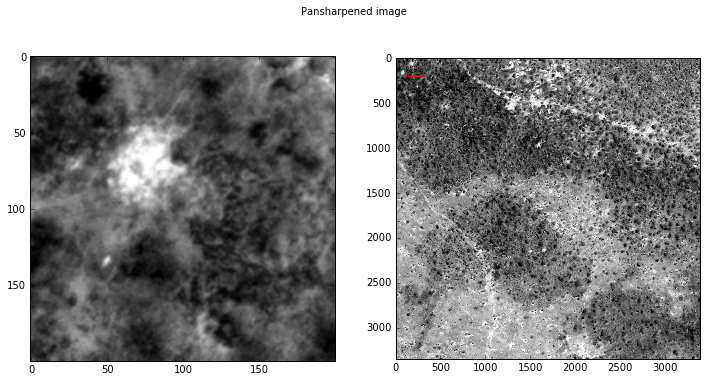

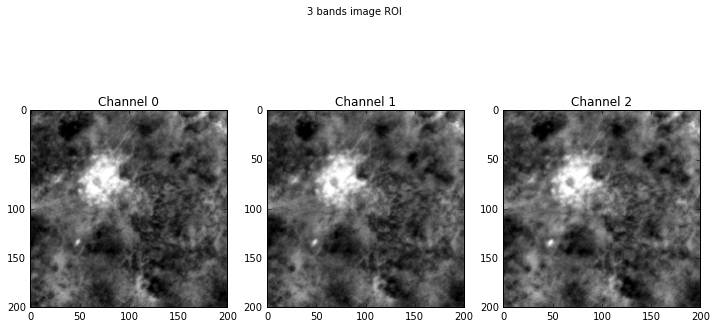

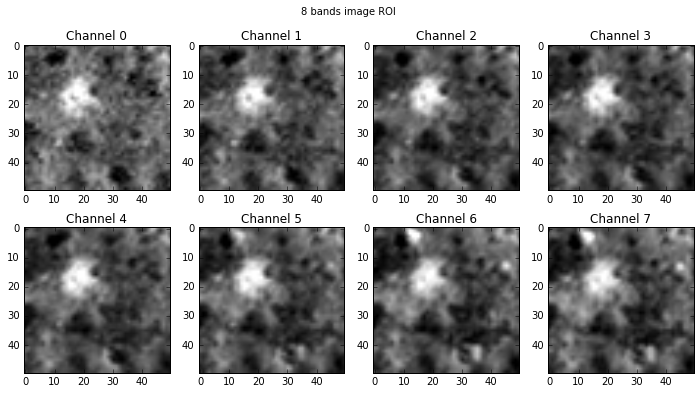

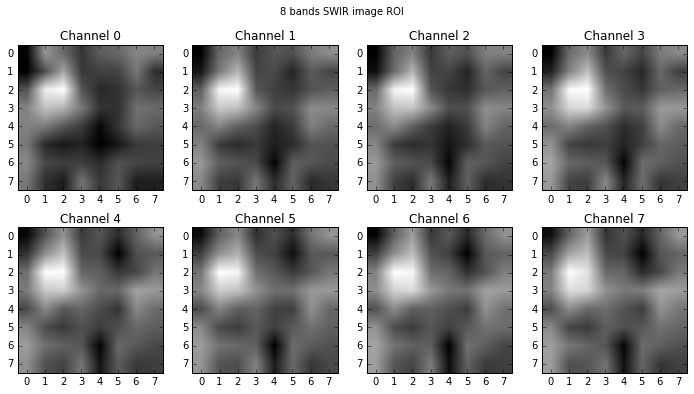

In [9]:
from ipywidgets import interact, IntSlider    



image_id = "6040_2_2"

img_pan = get_image_data(image_id, 'pan')
img_3b = get_image_data(image_id, '3b')
img_ms = get_image_data(image_id, 'ms')
img_swir = get_image_data(image_id, 'swir')

fig_size = (12, 6)
def interactive_visu(roi_x, roi_w, roi_y, roi_h):
    plt.figure(figsize=fig_size)
    roi = [roi_x,roi_x+roi_w,roi_y,roi_y+roi_h]
    plt.subplot(121)
    display_img_1b(img_pan, roi)
    
    plt.suptitle("Pansharpened image ROI")
    ax = plt.subplot(122)
    display_img_1b(img_pan)
    ax.add_patch(Rectangle((roi_x, roi_y), roi_w, roi_h, alpha=1, facecolor='none', edgecolor='red'))
    plt.suptitle("Pansharpened image")
    plt.figure(figsize=fig_size)
    display_img_3b(img_3b, roi)
    plt.suptitle("3 bands image ROI")
    plt.figure(figsize=fig_size)
    display_img_8b(img_ms, [int(r/4) for r in roi])
    plt.suptitle("8 bands image ROI")
    plt.figure(figsize=fig_size)
    display_img_8b(img_swir, [int(r/4/6.2) for r in roi])
    plt.suptitle("8 bands SWIR image ROI")

    
_ = interact(interactive_visu,           
         roi_x=IntSlider(value=100, min=0, max=3500, continuous_update=False), 
         roi_w=IntSlider(value=200, min=150, max=350, continuous_update=False), 
         roi_y=IntSlider(value=0, min=0, max=3500, continuous_update=False), 
         roi_h=IntSlider(value=200, min=150, max=350, continuous_update=False))

In [10]:
from shapely.wkt import loads
from shapely.affinity import scale

def get_unit_polygons(image_id):
    polygons = {}
    image_polygons = TRAIN_WKT[TRAIN_WKT['ImageId'] == image_id]
    assert not image_polygons.empty, "This is a test image"
    for class_type in range(1,len(LABELS)):
        polygons[class_type] = loads(image_polygons[image_polygons['ClassType'] == class_type].MultipolygonWKT.values[0])
    return polygons


def get_grid_params(image_id):
    params = GRID_SIZE[GRID_SIZE['ImageId'] == image_id][['Xmax', 'Ymin']]
    assert not params.empty, "No grid parameters for this image id : {}".format(image_id)
    return params.values[0]


def get_scalers(image_id, image_type):
    x_max, y_min = get_grid_params(image_id)
    image_shape = get_image_data(image_id, image_type, return_shape_only=True)   
    h, w = image_shape[:2]  # they are flipped so that mask_for_polygons works correctly
    w_ = w * (w * 1.0 / (w + 1.0))
    h_ = h * (h * 1.0 / (h + 1.0))
    return w_ / x_max, h_ / y_min


def get_resized_polygons(image_id, image_type):
    polygons = get_unit_polygons(image_id)
    x_scaler, y_scaler = get_scalers(image_id, '3b')
    resized_polygons = {}
    for class_type in polygons:
        poly = polygons[class_type]
        rpoly = scale(poly, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))  
        resized_polygons[class_type] = rpoly
    return resized_polygons

In [11]:
rpolygons = get_resized_polygons(image_id, '3b')   
poly = rpolygons[4][0]

from shapely.geometry import box
b = box(50, 1050, 500, 1450)
poly.intersects(b)

True

In [ ]:
res = b.intersection(poly)

In [ ]:
from shapely.ops import cascaded_union
from rtree import index
idx = index.Index()

# Populate R-tree index with bounds of grid cells
for pos, cell in enumerate(grid_cells):
    # assuming cell is a shapely object
    idx.insert(pos, cell.bounds)

# Loop through each Shapely polygon
for poly in polygons:
    # Merge cells that have overlapping bounding boxes
    merged_cells = cascaded_union([grid_cells[pos] for pos in idx.intersection(poly.bounds)])
    # Now do actual intersection
    print poly.intersection(merged_cells).area

In [ ]:
# poly2 = poly.intersection(b)
# poly2.boundary

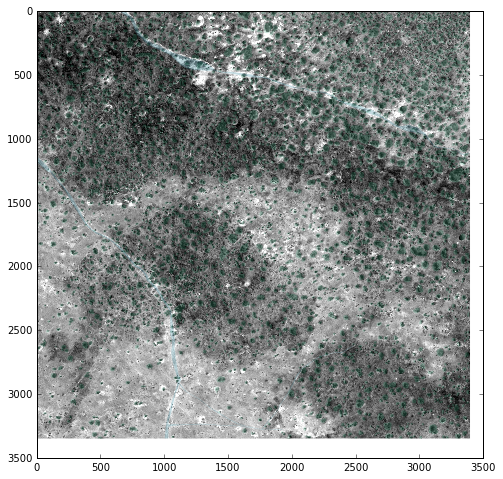

In [132]:
from shapely.geometry import box

def display_polygons(polygons, roi=None):
    if roi is not None:
        # roi is [T, W, L, H]
        b = box(roi[0], roi[2], roi[0] + roi[1], roi[2] + roi[3])
    ax = plt.gca()
    for class_type in polygons:
        for polygon in polygons[class_type]:            
            if roi is not None and polygon.intersects(rect):
                polygon
                

            mpl_poly = Polygon(np.array(polygon.exterior), color=plt.cm.Set1(class_type*10), lw=0, alpha=0.3)
            ax.add_patch(mpl_poly)
    ax.relim()
    ax.autoscale_view()    
    # ax.legend()
    
    
rpolygons = get_resized_polygons(image_id, '3b')   
# polygons = get_unit_polygons(image_id)   
plt.figure(figsize=(10, 8))
# plt.subplot(121)
display_img_1b(img_pan)
display_polygons(rpolygons)

# plt.subplot(122)
# display_polygons(rpolygons)